In [1]:
using Revise

In [2]:
using OpticalBlochEquations

┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1423


In [36]:
using Plots
using BenchmarkTools
using DifferentialEquations
using LinearAlgebra

In [67]:
const λ = @with_unit 606 "nm"
const Γ = @with_unit 2π * 8 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
const k = 2π / λ
;

In [68]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
];

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [69]:
function find_idx_for_time(time_to_find, times, backwards)
    if backwards
        times = reverse(times)
    end
    start_time = times[1]
    found_idx = 0
    for (i, time) in enumerate(times)
        if abs(start_time - time) > time_to_find
            found_idx = i
            break
        end
    end
    if backwards
        found_idx = length(times) + 1 - found_idx
    end
    
    return found_idx
end;

In [70]:
function calculate_force_from_period(p, sol, force_idxs)
    """
    Integrates the force resulting from `sol` over a time period designated by `period`.
    """
    force = 0.0
    for i in force_idxs
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    t = sol.t[force_idxs[end]] - sol.t[force_idxs[1]]
    return force / (length(force_idxs))
end;

In [107]:
# Generate states
m1 = manifold(F=1, ω=0, μ=0)
m2 = manifold(F=2, ω=E₀, μ=0, Γ=Γ)
states = [m1.states..., m2.states...]

δ = -2.5Γ
s = 1.0

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

l1 = Laser(-x, rotate_pol(σ_m, -x), E₀ + δ, s)
l2 = Laser( x, rotate_pol(σ_p,  x), E₀ + δ, s)

l3 = Laser(-y, rotate_pol(σ_m, -y), E₀ + δ, s)
l4 = Laser( y, rotate_pol(σ_p,  y), E₀ + δ, s)

l5 = Laser(-z, rotate_pol(σ_m, -z), E₀ + δ, s)
l6 = Laser( z, rotate_pol(σ_p,  z), E₀ + δ, s)

lasers = [l1, l2, l3, l4, l5, l6]

d = zeros(8, 8, 3)
d_1 = [
    0.0 0.0 0.40824829 0.0 0.0;
    0.0 0.0 0.0 0.70710678 0.0;
    0.0 0.0 0.0 0.0 1.0
]
d_2 = [
    0.0 -0.70710678 0.0 0.0 0.0;
    0.0 0.0 -0.81649658 0.0 0.0;
    0.0 0.0 0.0 -0.70710678 0.0
]
d_3 = [
    1.0 0.0 0.0 0.0 0.0;
    0.0 0.70710678 0.0 0.0 0.0;
    0.0 0.0 0.40824829 0.0 0.0
]

d[1:3,4:8,1] = d_1
d[4:8,1:3,1] = d_1'
d[1:3,4:8,2] = d_2
d[4:8,1:3,2] = d_2'
d[1:3,4:8,3] = d_3
d[4:8,1:3,3] = d_3'
;

In [108]:
using StaticArrays

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# Frequencies are rounded to a multiple of `freq_res`, and are measured in units of Γ
freq_res = 1e-3

(dρ, ρ, p) = obe(states, lasers, d, ρ0, freq_res=freq_res)
ρ!(dρ, ρ, p, 0.0)

ω_min = freq_res
period = 2π / ω_min
display(period)

6283.185307179586

In [109]:
@btime ρ!($dρ, $ρ, $p, $1.0)

  1.330 μs (0 allocations: 0 bytes)


In [110]:
t_end = 2π * 2000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 200000)

p.particle.r0 = SVector(0, 0, 0) / (1 / k)
p.particle.v = SVector(0.0, 0.0, 0.1)
p.particle.v = round_vel(p.particle.v, λ, Γ, freq_res) / (Γ / k)
println(p.particle.v)

prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))

# @time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, dense=false, saveat=times)
@time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, dense=false, saveat=times)
;

[0.0, 0.0, 0.021]
  0.893430 seconds (269.93 k allocations: 253.457 MiB, 1.20% gc time)


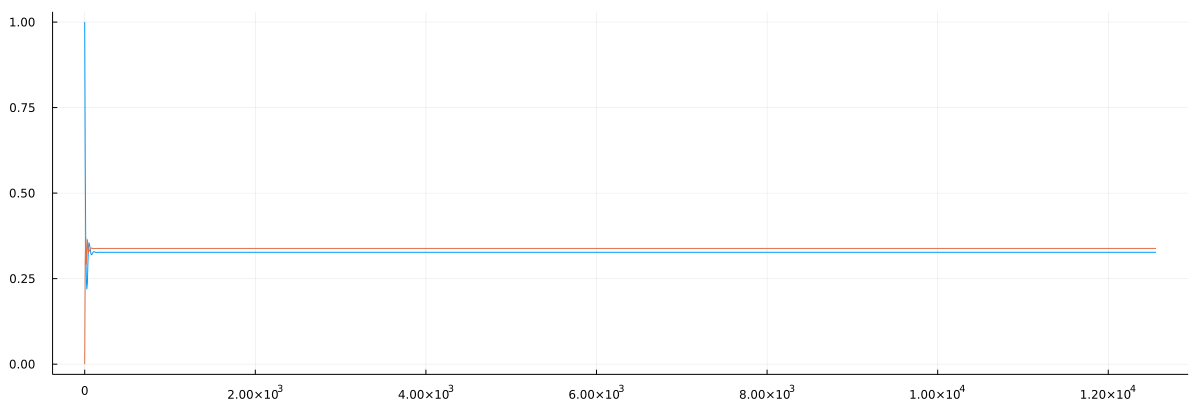

In [111]:
plot(sol.t[1:100:end], [real(u[1,1]) for u in sol.u[1:100:end]], size=(1200, 400))
plot!(sol.t[1:100:end], [real(u[2,2]) for u in sol.u[1:100:end]], legend=false)

In [112]:
offset = 100
period_idx = find_idx_for_time(period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
force = calculate_force_from_period(p, sol, force_idxs)

println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[4:end])))
print("Force: ", (Γ / (2π / λ)) * (ħ * k * Γ * force / M))

Excited population: 0.0700136696346352
Force: 7615.320449370934

In [150]:
vs = collect(0.0:0.50:5.00)
forces = zeros(length(vs))
exc_pop = zeros(length(vs))

t_end = 2π * 2000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 200000)

@time begin
    Threads.@threads for i in 1:length(vs)
        
        v = vs[i]
        
        previous_force = 0.0
        force = 1.0
        error = 1.0
        
        p_ = deepcopy(p)
        
        p_.particle.r0 = SVector(0.0, 0.0, 0.0) / (1 / k)
        p_.particle.v = SVector(0.0, 2.0, v)
        p_.particle.v = round_vel(p_.particle.v, λ, Γ, freq_res) / (Γ / k)
        
        vs[i] = sqrt(sum(p_.particle.v.^2))
        
        ρ0 = zeros(ComplexF64,(8, 8))
        ρ0[1,1] = 1.0

        prob = ODEProblem(ρ!, ρ0, tspan, p_)
        sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, saveat=times)

        offset = 0
        period_idx = find_idx_for_time(period, sol.t, true)
        force_idxs = (period_idx - offset):(length(times) - offset)
        
        previous_force = force
        force = calculate_force_from_period(p_, sol, force_idxs)

        forces[i] = force
        exc_pop[i] = real(sum(diag(mean(sol.u[force_idxs]))[13:end]))
            
    end
end
forces_ħkΓ = (Γ / k) * (forces) * 1e3
;

  7.050743 seconds (3.41 M allocations: 3.456 GiB, 5.16% gc time, 0.70% compilation time)


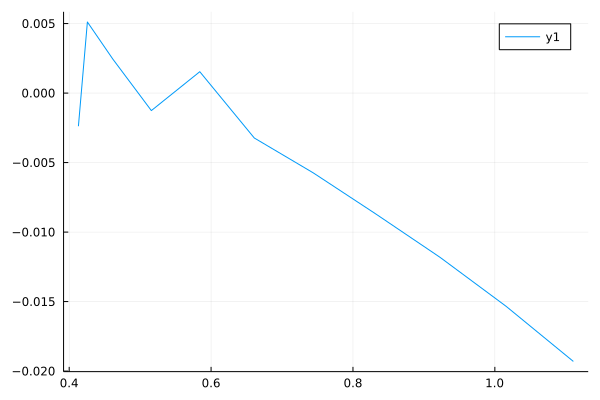

In [151]:
plot(vs, real.(forces), size=(600,400))